In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM



In [13]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [14]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [15]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [16]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

(828, 10)
(828,)


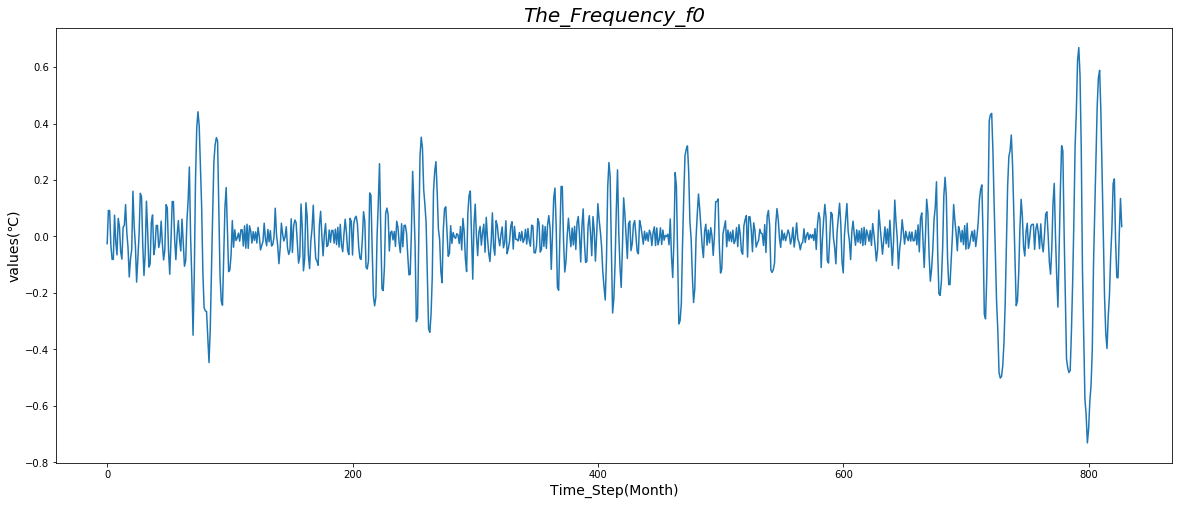

Epoch 1/200
 - 174s - loss: 0.0210
Epoch 2/200
 - 22s - loss: 0.0209
Epoch 3/200
 - 22s - loss: 0.0205
Epoch 4/200
 - 22s - loss: 0.0199
Epoch 5/200
 - 21s - loss: 0.0188
Epoch 6/200
 - 22s - loss: 0.0176
Epoch 7/200
 - 22s - loss: 0.0177
Epoch 8/200
 - 22s - loss: 0.0166
Epoch 9/200
 - 22s - loss: 0.0166
Epoch 10/200
 - 22s - loss: 0.0166
Epoch 11/200
 - 22s - loss: 0.0154
Epoch 12/200
 - 22s - loss: 0.0159
Epoch 13/200
 - 22s - loss: 0.0154
Epoch 14/200
 - 22s - loss: 0.0148
Epoch 15/200
 - 22s - loss: 0.0149
Epoch 16/200
 - 22s - loss: 0.0141
Epoch 17/200
 - 22s - loss: 0.0145
Epoch 18/200
 - 22s - loss: 0.0137
Epoch 19/200
 - 22s - loss: 0.0136
Epoch 20/200
 - 22s - loss: 0.0135
Epoch 21/200
 - 21s - loss: 0.0135
Epoch 22/200
 - 22s - loss: 0.0142
Epoch 23/200
 - 22s - loss: 0.0137
Epoch 24/200
 - 22s - loss: 0.0136
Epoch 25/200
 - 22s - loss: 0.0131
Epoch 26/200
 - 22s - loss: 0.0129
Epoch 27/200
 - 22s - loss: 0.0141
Epoch 28/200
 - 22s - loss: 0.0132
Epoch 29/200
 - 22s - loss: 

(66, 12)


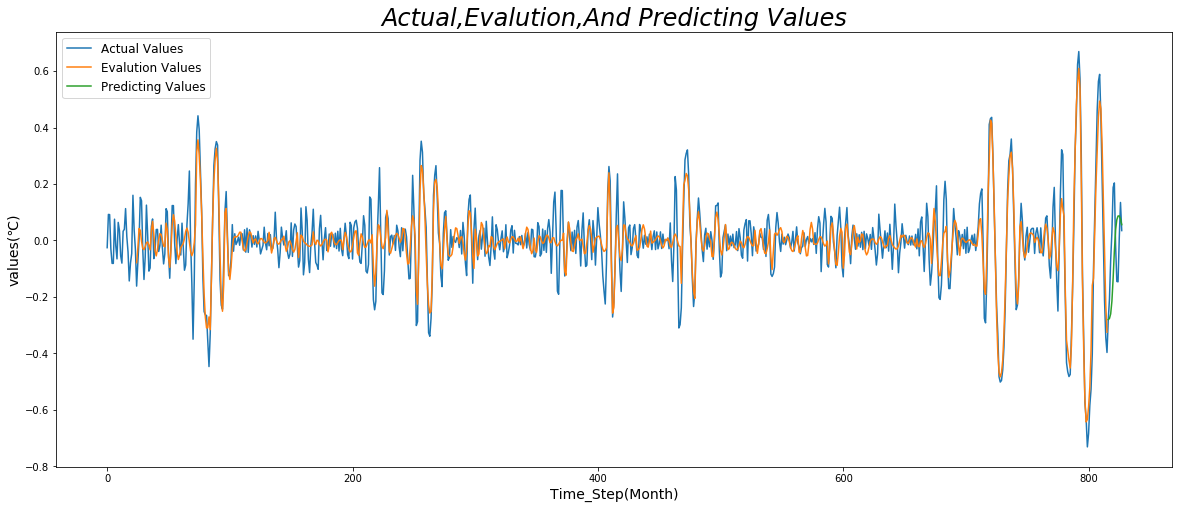

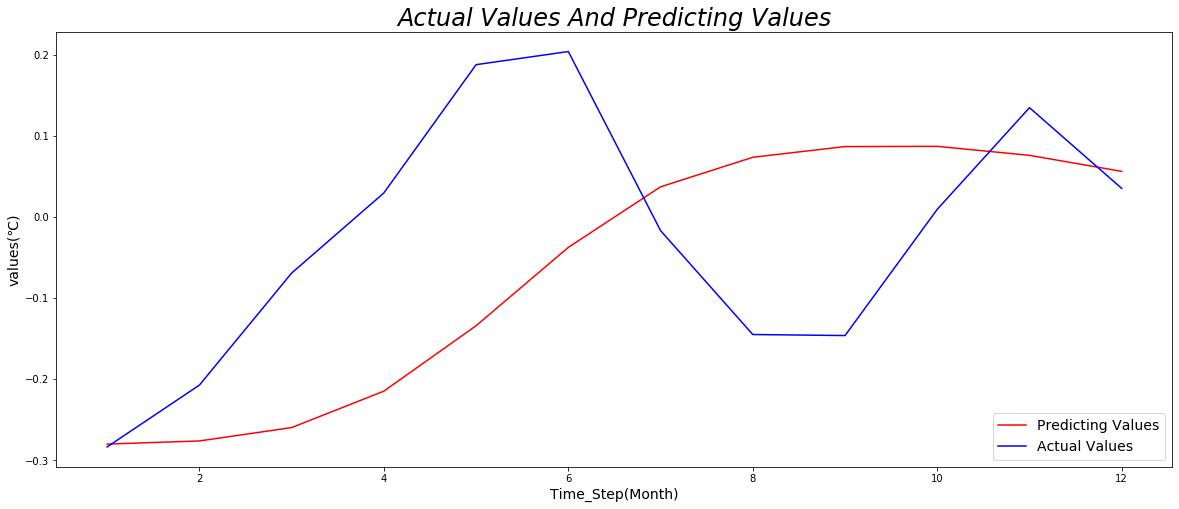

(828,)


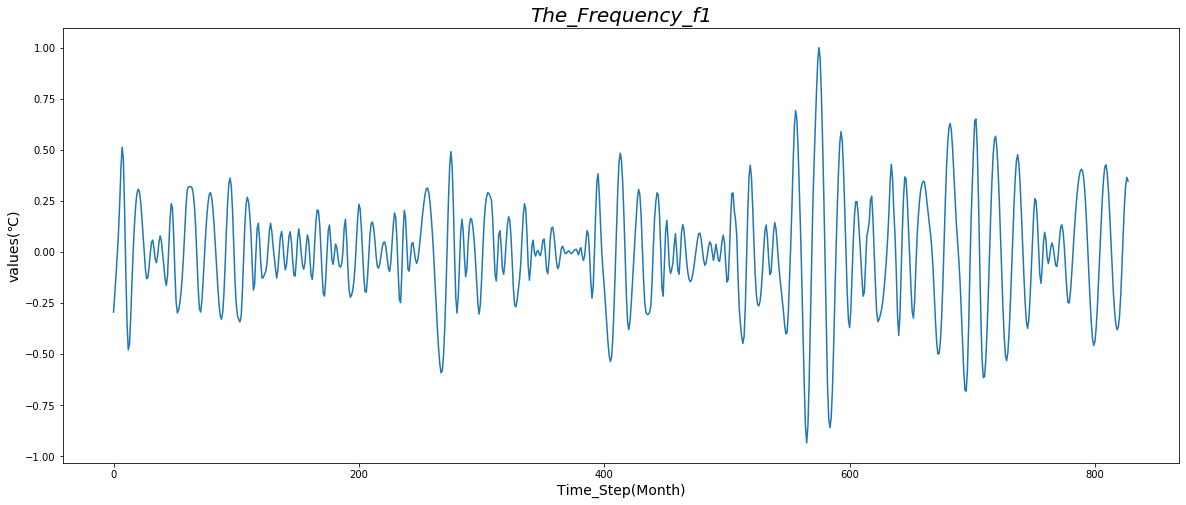

Epoch 1/200
 - 105s - loss: 0.0650
Epoch 2/200
 - 15s - loss: 0.0567
Epoch 3/200
 - 15s - loss: 0.0483
Epoch 4/200
 - 15s - loss: 0.0485
Epoch 5/200
 - 16s - loss: 0.0442
Epoch 6/200
 - 22s - loss: 0.0427
Epoch 7/200
 - 22s - loss: 0.0394
Epoch 8/200
 - 22s - loss: 0.0406
Epoch 9/200
 - 19s - loss: 0.0382
Epoch 10/200
 - 16s - loss: 0.0357
Epoch 11/200
 - 16s - loss: 0.0352
Epoch 12/200
 - 16s - loss: 0.0353
Epoch 13/200
 - 16s - loss: 0.0333
Epoch 14/200
 - 16s - loss: 0.0355
Epoch 15/200
 - 19s - loss: 0.0318
Epoch 16/200
 - 21s - loss: 0.0314
Epoch 17/200
 - 21s - loss: 0.0307
Epoch 18/200
 - 21s - loss: 0.0311
Epoch 19/200
 - 22s - loss: 0.0296
Epoch 20/200
 - 21s - loss: 0.0295
Epoch 21/200
 - 21s - loss: 0.0304
Epoch 22/200
 - 21s - loss: 0.0299
Epoch 23/200
 - 21s - loss: 0.0284
Epoch 24/200
 - 21s - loss: 0.0284
Epoch 25/200
 - 21s - loss: 0.0271
Epoch 26/200
 - 21s - loss: 0.0275
Epoch 27/200
 - 21s - loss: 0.0278
Epoch 28/200
 - 21s - loss: 0.0258
Epoch 29/200
 - 21s - loss: 

(66, 12)


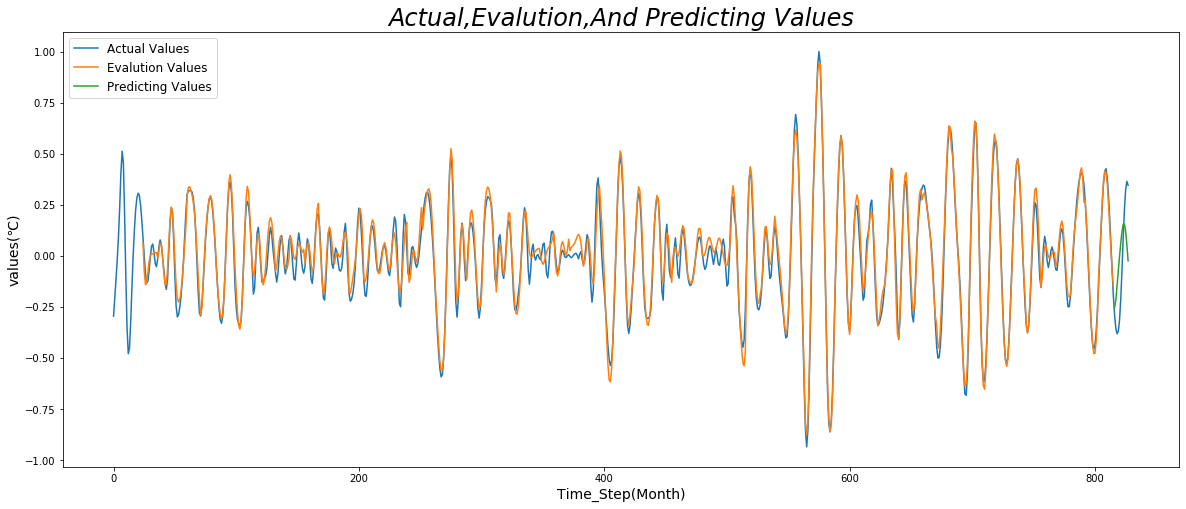

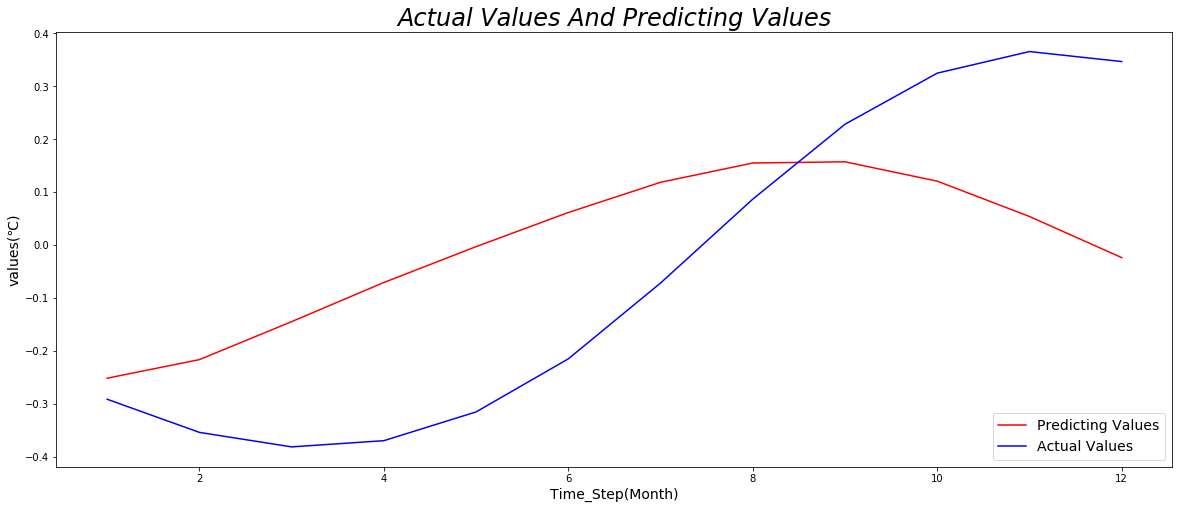

(828,)


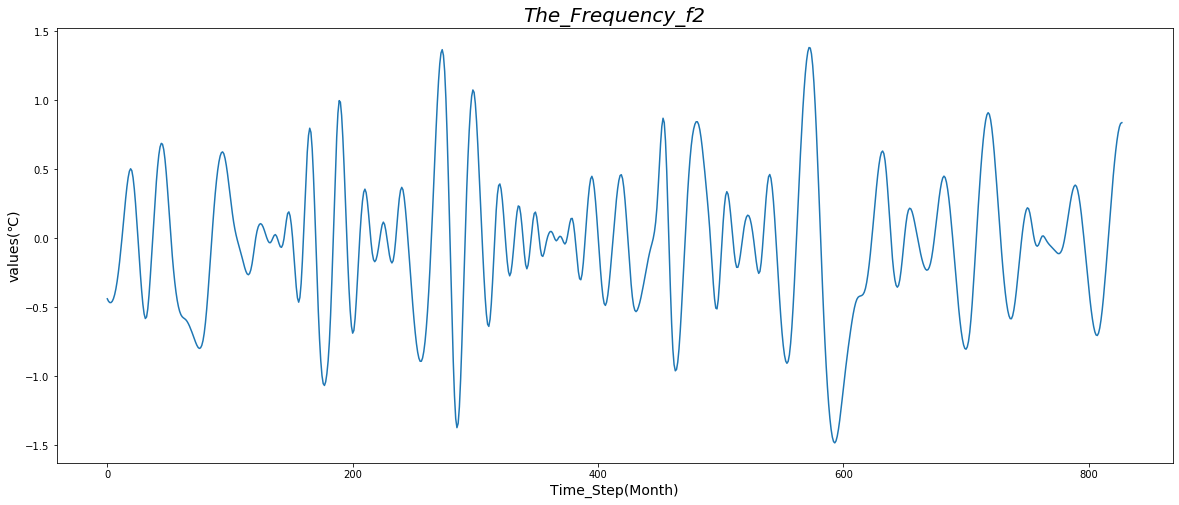

Epoch 1/200
 - 40s - loss: 0.2363
Epoch 2/200
 - 21s - loss: 0.2212
Epoch 3/200
 - 21s - loss: 0.2096
Epoch 4/200
 - 21s - loss: 0.1563
Epoch 5/200
 - 21s - loss: 0.1253
Epoch 6/200
 - 21s - loss: 0.1145
Epoch 7/200
 - 21s - loss: 0.1215
Epoch 8/200
 - 21s - loss: 0.1014
Epoch 9/200
 - 22s - loss: 0.0964
Epoch 10/200
 - 22s - loss: 0.0886
Epoch 11/200
 - 21s - loss: 0.0835
Epoch 12/200
 - 20s - loss: 0.0764
Epoch 13/200
 - 17s - loss: 0.0780
Epoch 14/200
 - 17s - loss: 0.0833
Epoch 15/200
 - 17s - loss: 0.0730
Epoch 16/200
 - 17s - loss: 0.0720
Epoch 17/200
 - 20s - loss: 0.0671
Epoch 18/200
 - 22s - loss: 0.0661
Epoch 19/200
 - 22s - loss: 0.0595
Epoch 20/200
 - 22s - loss: 0.0650
Epoch 21/200
 - 21s - loss: 0.0637
Epoch 22/200
 - 21s - loss: 0.0675
Epoch 23/200
 - 21s - loss: 0.0575
Epoch 24/200
 - 21s - loss: 0.0631
Epoch 25/200
 - 21s - loss: 0.0597
Epoch 26/200
 - 21s - loss: 0.0541
Epoch 27/200
 - 21s - loss: 0.0518
Epoch 28/200
 - 21s - loss: 0.0481
Epoch 29/200
 - 21s - loss: 0

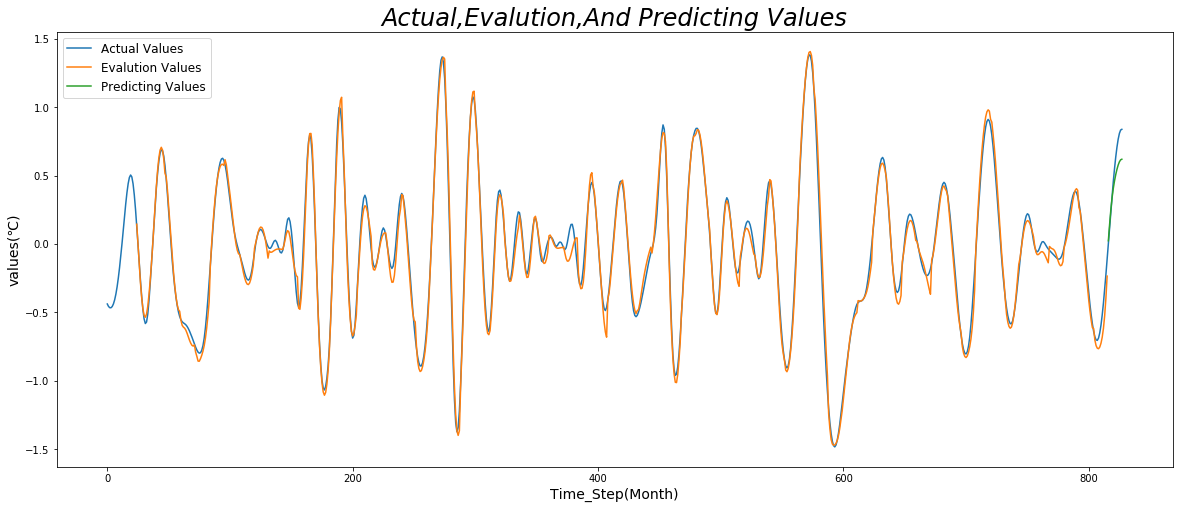

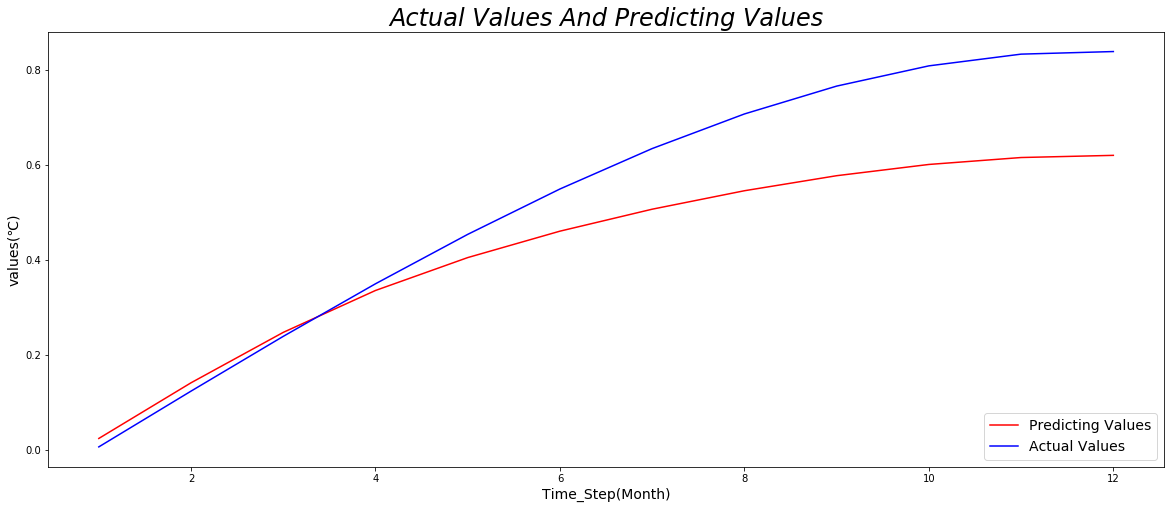

(828,)


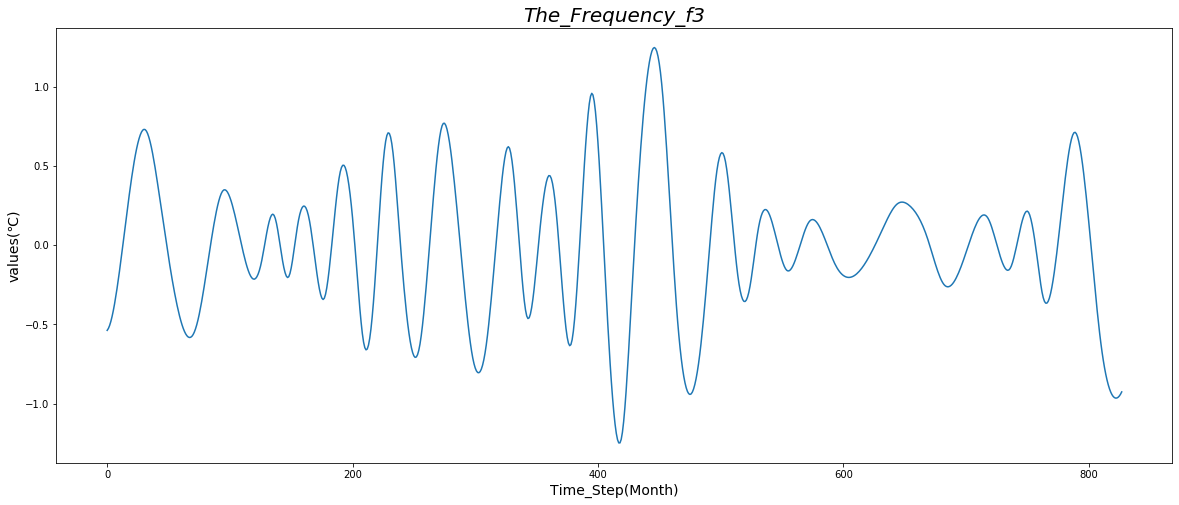

Epoch 1/200
 - 65s - loss: 0.1485
Epoch 2/200
 - 21s - loss: 0.1106
Epoch 3/200
 - 21s - loss: 0.0748
Epoch 4/200
 - 21s - loss: 0.0636
Epoch 5/200
 - 21s - loss: 0.0429
Epoch 6/200
 - 21s - loss: 0.0365
Epoch 7/200
 - 21s - loss: 0.0280
Epoch 8/200
 - 21s - loss: 0.0372
Epoch 9/200
 - 21s - loss: 0.0216
Epoch 10/200
 - 21s - loss: 0.0203
Epoch 11/200
 - 21s - loss: 0.0188
Epoch 12/200
 - 21s - loss: 0.0162
Epoch 13/200
 - 21s - loss: 0.0181
Epoch 14/200
 - 21s - loss: 0.0252
Epoch 15/200
 - 21s - loss: 0.0259
Epoch 16/200
 - 21s - loss: 0.0196
Epoch 17/200
 - 21s - loss: 0.0173
Epoch 18/200
 - 21s - loss: 0.0146
Epoch 19/200
 - 21s - loss: 0.0138
Epoch 20/200
 - 21s - loss: 0.0147
Epoch 21/200
 - 21s - loss: 0.0118
Epoch 22/200
 - 21s - loss: 0.0139
Epoch 23/200
 - 21s - loss: 0.0156
Epoch 24/200
 - 21s - loss: 0.0155
Epoch 25/200
 - 21s - loss: 0.0140
Epoch 26/200
 - 21s - loss: 0.0132
Epoch 27/200
 - 21s - loss: 0.0134
Epoch 28/200
 - 19s - loss: 0.0108
Epoch 29/200
 - 17s - loss: 0

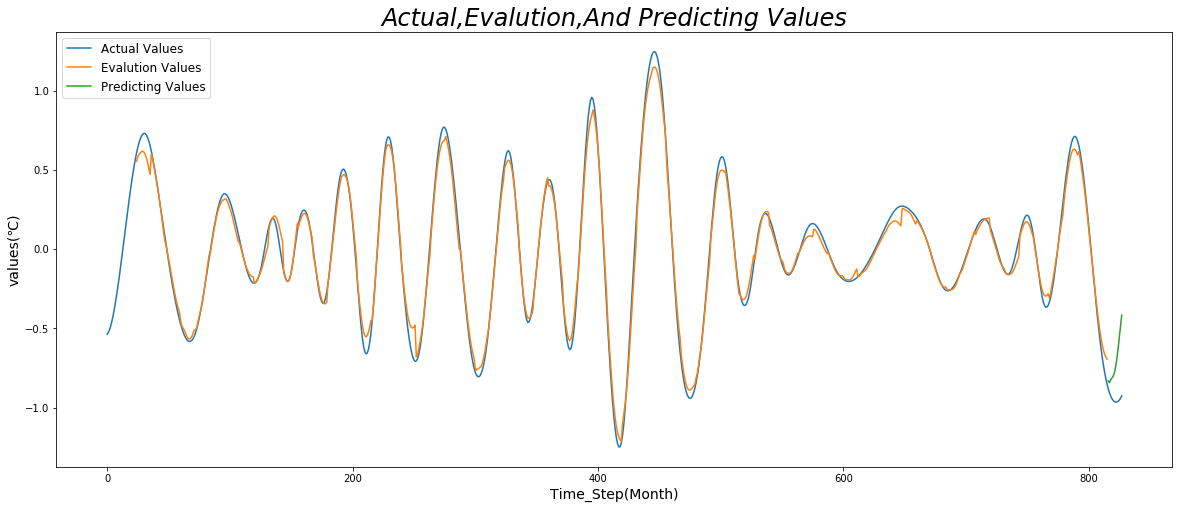

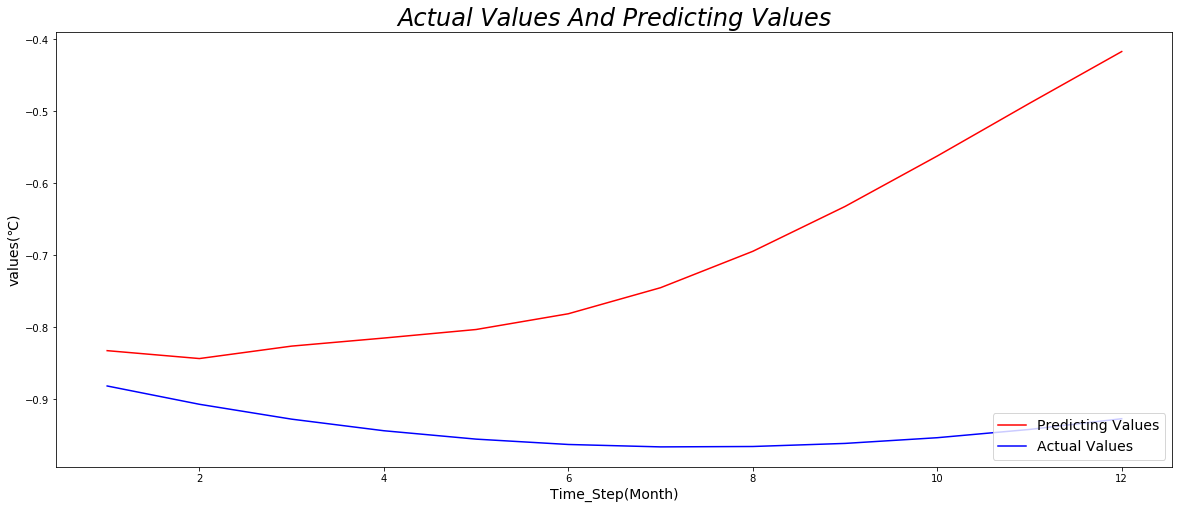

(828,)


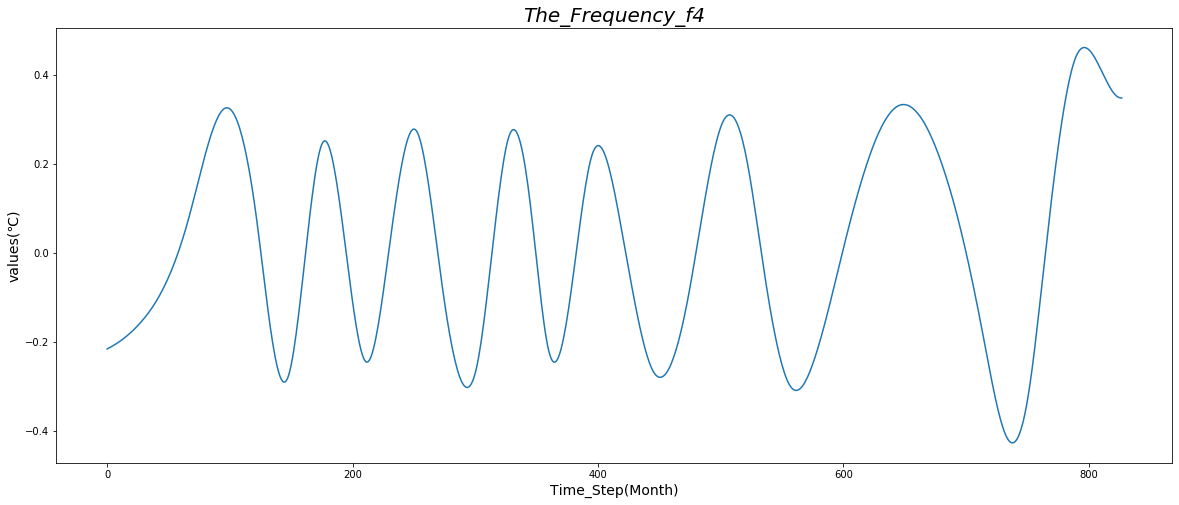

Epoch 1/200
 - 58s - loss: 0.0370
Epoch 2/200
 - 21s - loss: 0.0130
Epoch 3/200
 - 21s - loss: 0.0073
Epoch 4/200
 - 21s - loss: 0.0056
Epoch 5/200
 - 21s - loss: 0.0050
Epoch 6/200
 - 21s - loss: 0.0035
Epoch 7/200
 - 21s - loss: 0.0031
Epoch 8/200
 - 21s - loss: 0.0029
Epoch 9/200
 - 21s - loss: 0.0027
Epoch 10/200
 - 21s - loss: 0.0018
Epoch 11/200
 - 21s - loss: 0.0017
Epoch 12/200
 - 21s - loss: 0.0021
Epoch 13/200
 - 21s - loss: 0.0021
Epoch 14/200
 - 21s - loss: 0.0017
Epoch 15/200
 - 21s - loss: 0.0017
Epoch 16/200
 - 21s - loss: 0.0018
Epoch 17/200
 - 21s - loss: 0.0018
Epoch 18/200
 - 21s - loss: 0.0015
Epoch 19/200
 - 21s - loss: 0.0017
Epoch 20/200
 - 22s - loss: 0.0022
Epoch 21/200
 - 21s - loss: 0.0016
Epoch 22/200
 - 21s - loss: 0.0015
Epoch 23/200
 - 21s - loss: 0.0015
Epoch 24/200
 - 21s - loss: 0.0013
Epoch 25/200
 - 21s - loss: 0.0016
Epoch 26/200
 - 21s - loss: 0.0014
Epoch 27/200
 - 21s - loss: 0.0013
Epoch 28/200
 - 21s - loss: 0.0014
Epoch 29/200
 - 21s - loss: 0

(66, 12)


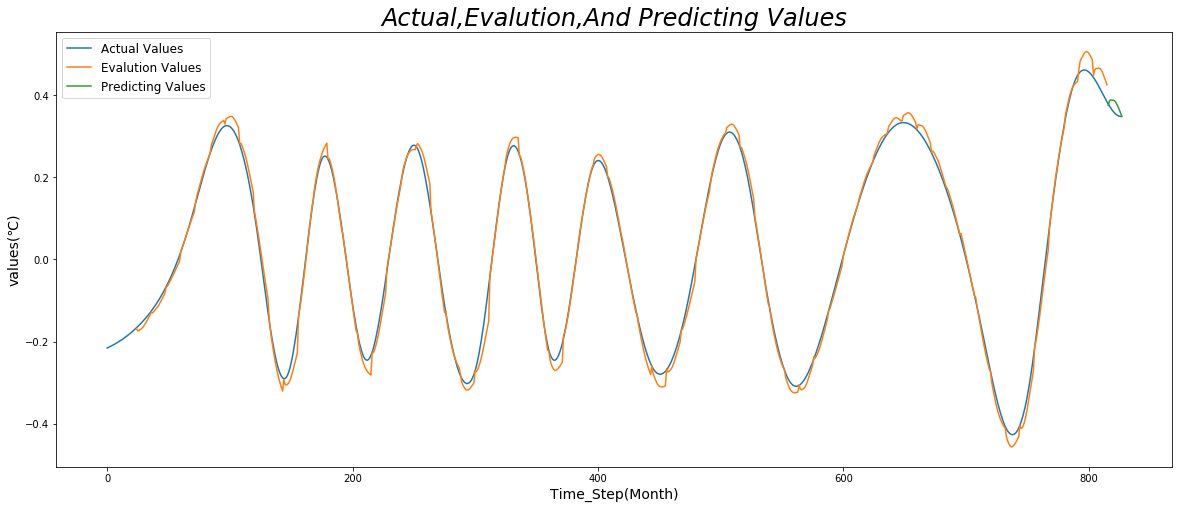

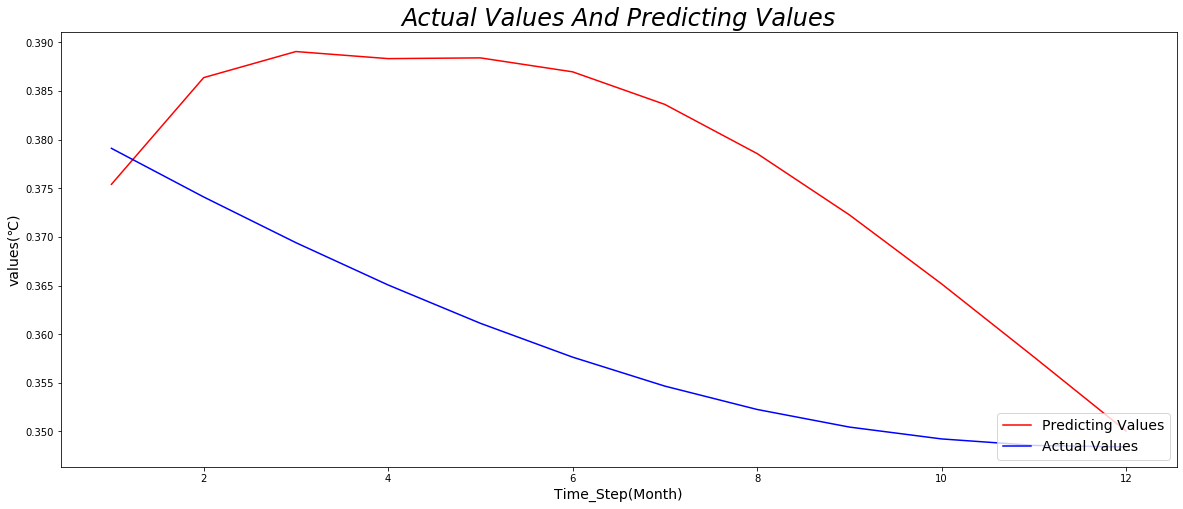

(828,)


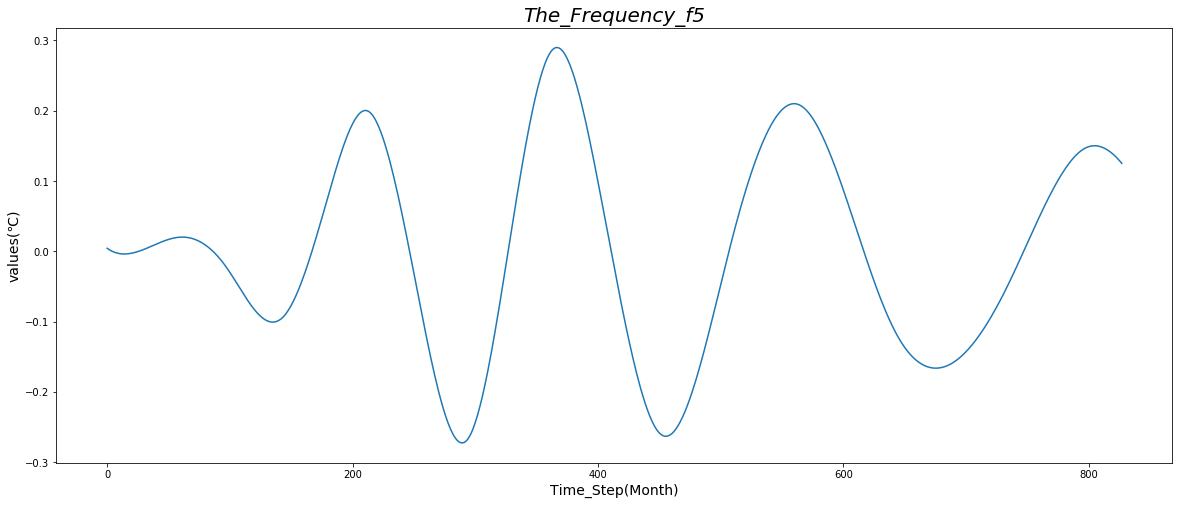

Epoch 1/200
 - 131s - loss: 0.0144
Epoch 2/200
 - 26s - loss: 0.0060
Epoch 3/200
 - 26s - loss: 0.0019
Epoch 4/200
 - 26s - loss: 0.0014
Epoch 5/200
 - 26s - loss: 8.5856e-04
Epoch 6/200
 - 28s - loss: 6.6997e-04
Epoch 7/200
 - 26s - loss: 5.2749e-04
Epoch 8/200
 - 26s - loss: 4.3471e-04
Epoch 9/200
 - 26s - loss: 4.1400e-04
Epoch 10/200
 - 26s - loss: 3.6045e-04
Epoch 11/200
 - 26s - loss: 3.4153e-04
Epoch 12/200
 - 26s - loss: 3.7605e-04
Epoch 13/200
 - 26s - loss: 3.4265e-04
Epoch 14/200
 - 26s - loss: 3.4475e-04
Epoch 15/200
 - 26s - loss: 3.1725e-04
Epoch 16/200
 - 16s - loss: 2.9598e-04
Epoch 17/200
 - 20s - loss: 4.5929e-04
Epoch 18/200
 - 24s - loss: 4.0896e-04
Epoch 19/200
 - 25s - loss: 3.3362e-04
Epoch 20/200
 - 25s - loss: 3.8635e-04
Epoch 21/200
 - 25s - loss: 4.0050e-04
Epoch 22/200
 - 25s - loss: 3.4127e-04
Epoch 23/200
 - 24s - loss: 3.0591e-04
Epoch 24/200
 - 24s - loss: 2.7504e-04
Epoch 25/200
 - 25s - loss: 3.3644e-04
Epoch 26/200
 - 25s - loss: 4.5166e-04
Epoch 27/2

(66, 12)


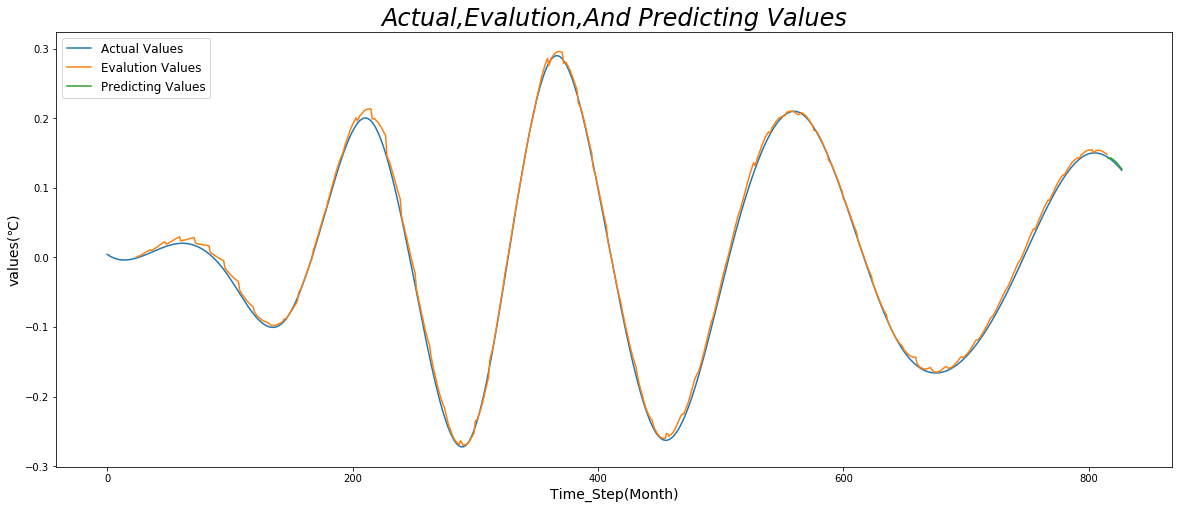

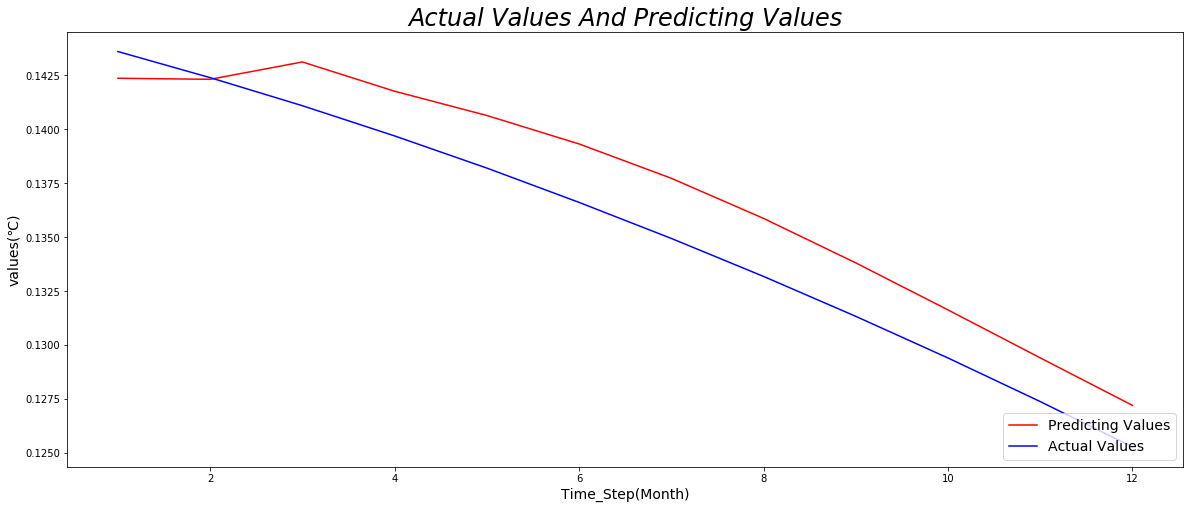

(828,)


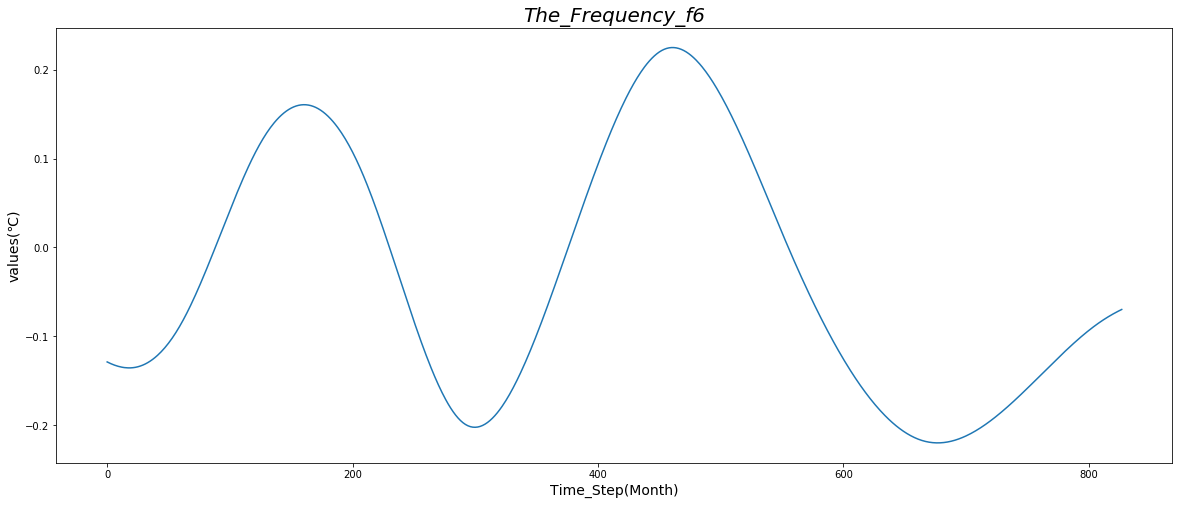

Epoch 1/200
 - 52s - loss: 0.0087
Epoch 2/200
 - 20s - loss: 0.0035
Epoch 3/200
 - 19s - loss: 0.0022
Epoch 4/200
 - 19s - loss: 0.0012
Epoch 5/200
 - 20s - loss: 6.2114e-04
Epoch 6/200
 - 20s - loss: 4.3545e-04
Epoch 7/200
 - 20s - loss: 3.9181e-04
Epoch 8/200
 - 20s - loss: 3.5267e-04
Epoch 9/200
 - 20s - loss: 3.2744e-04
Epoch 10/200
 - 20s - loss: 3.3329e-04
Epoch 11/200
 - 20s - loss: 3.0116e-04
Epoch 12/200
 - 20s - loss: 3.4688e-04
Epoch 13/200
 - 14s - loss: 2.8806e-04
Epoch 14/200
 - 17s - loss: 2.5735e-04
Epoch 15/200
 - 20s - loss: 2.7041e-04
Epoch 16/200
 - 19s - loss: 2.7221e-04
Epoch 17/200
 - 19s - loss: 2.5117e-04
Epoch 18/200
 - 20s - loss: 2.3635e-04
Epoch 19/200
 - 19s - loss: 2.5257e-04
Epoch 20/200
 - 19s - loss: 2.2400e-04
Epoch 21/200
 - 19s - loss: 2.8220e-04
Epoch 22/200
 - 19s - loss: 3.0542e-04
Epoch 23/200
 - 19s - loss: 2.4173e-04
Epoch 24/200
 - 19s - loss: 2.3111e-04
Epoch 25/200
 - 20s - loss: 2.1259e-04
Epoch 26/200
 - 19s - loss: 2.3627e-04
Epoch 27/20

(66, 12)


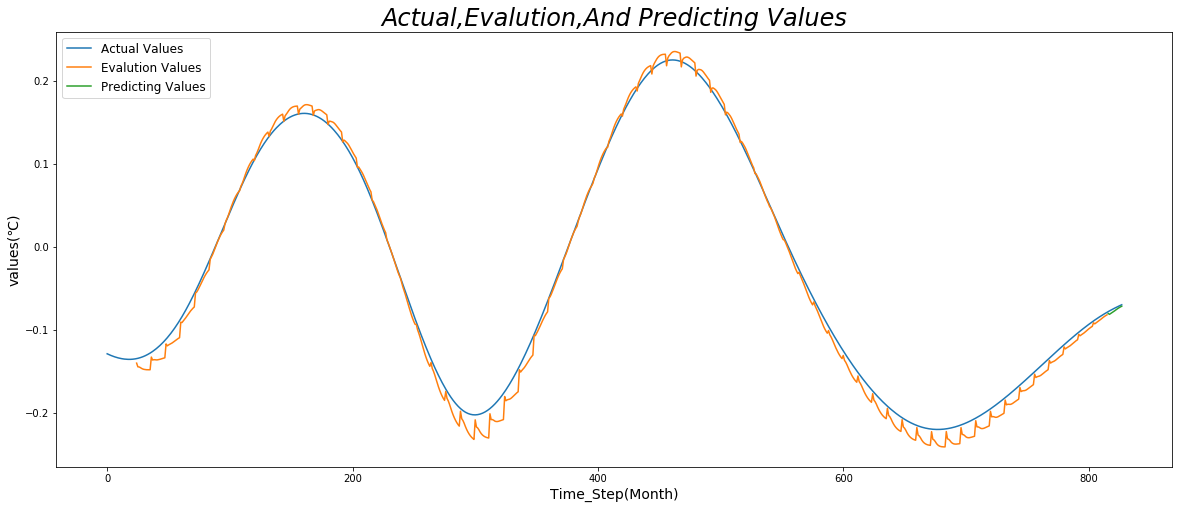

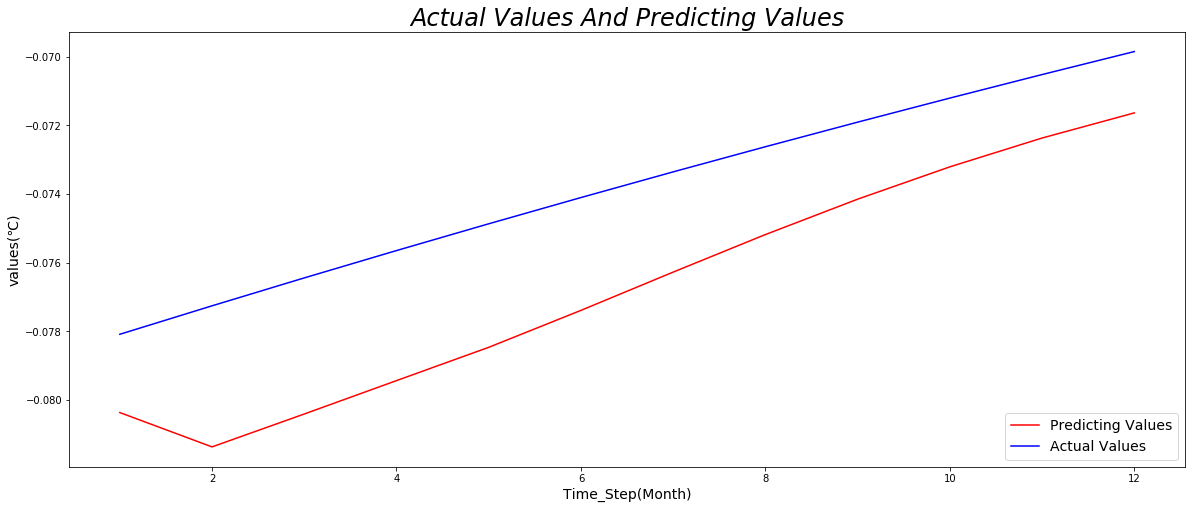

(828,)


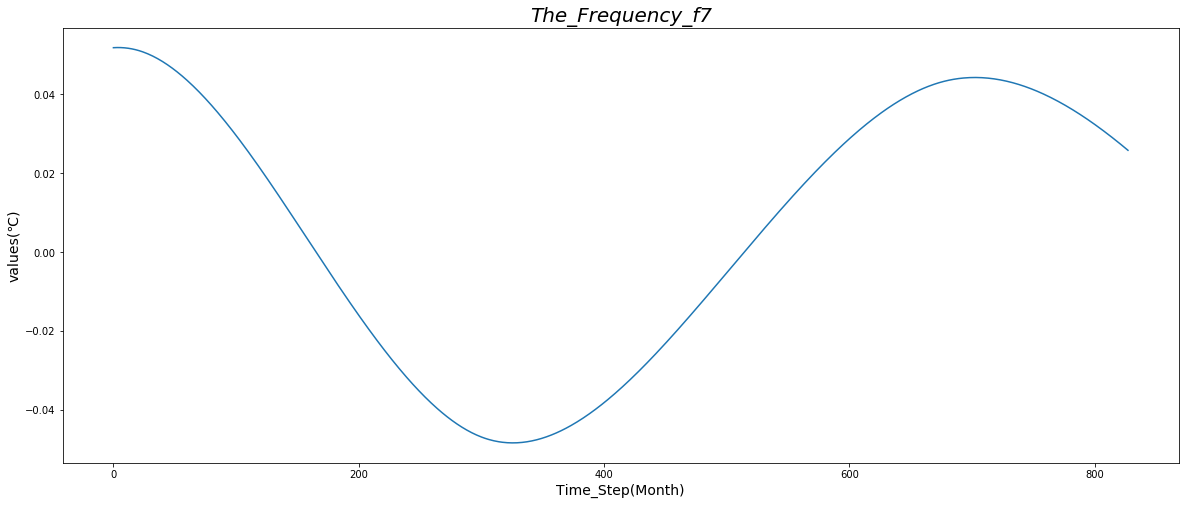

Epoch 1/200
 - 45s - loss: 7.8092e-04
Epoch 2/200
 - 22s - loss: 2.0964e-04
Epoch 3/200
 - 22s - loss: 1.2147e-04
Epoch 4/200
 - 22s - loss: 9.3056e-05
Epoch 5/200
 - 22s - loss: 7.1127e-05
Epoch 6/200
 - 22s - loss: 5.9353e-05
Epoch 7/200
 - 22s - loss: 5.4819e-05
Epoch 8/200
 - 22s - loss: 4.8630e-05
Epoch 9/200
 - 22s - loss: 5.0568e-05
Epoch 10/200
 - 22s - loss: 4.8692e-05
Epoch 11/200
 - 22s - loss: 4.4595e-05
Epoch 12/200
 - 22s - loss: 3.8065e-05
Epoch 13/200
 - 22s - loss: 3.2583e-05
Epoch 14/200
 - 24s - loss: 3.2485e-05
Epoch 15/200
 - 25s - loss: 4.4512e-05
Epoch 16/200
 - 23s - loss: 3.3706e-05
Epoch 17/200
 - 22s - loss: 2.5460e-05
Epoch 18/200
 - 22s - loss: 2.1704e-05
Epoch 19/200
 - 22s - loss: 1.9440e-05
Epoch 20/200
 - 22s - loss: 2.8485e-05
Epoch 21/200
 - 22s - loss: 2.4527e-05
Epoch 22/200
 - 22s - loss: 1.9479e-05
Epoch 23/200
 - 22s - loss: 1.5534e-05
Epoch 24/200
 - 22s - loss: 1.5425e-05
Epoch 25/200
 - 22s - loss: 1.4099e-05
Epoch 26/200
 - 22s - loss: 1.9573

(66, 12)


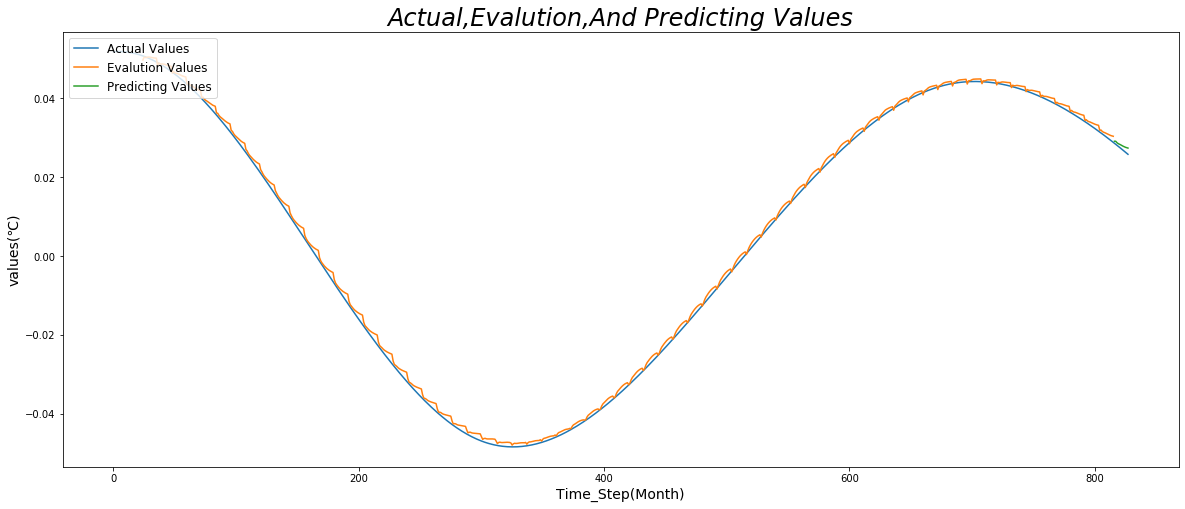

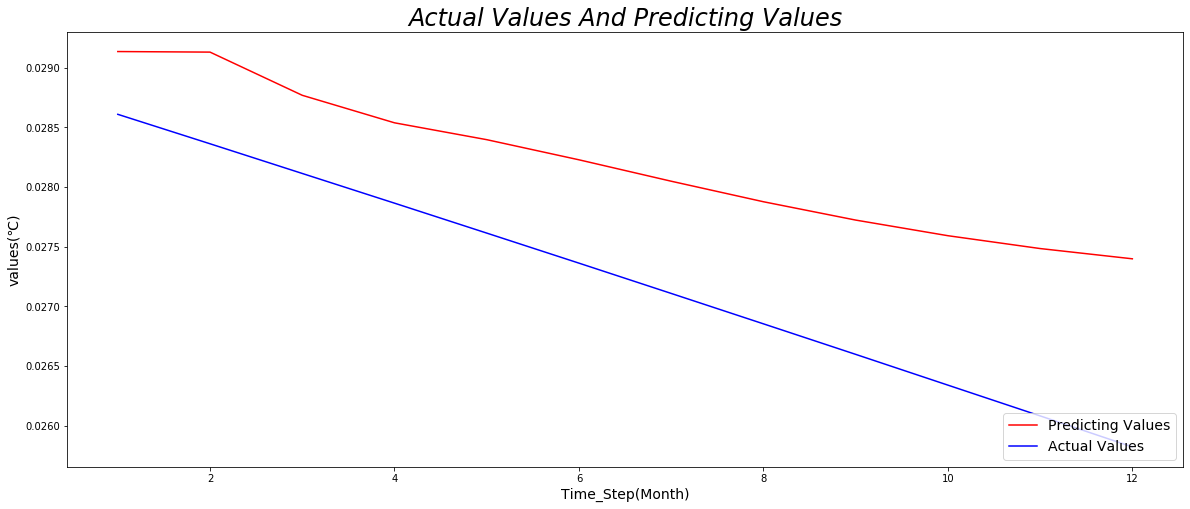

(828,)


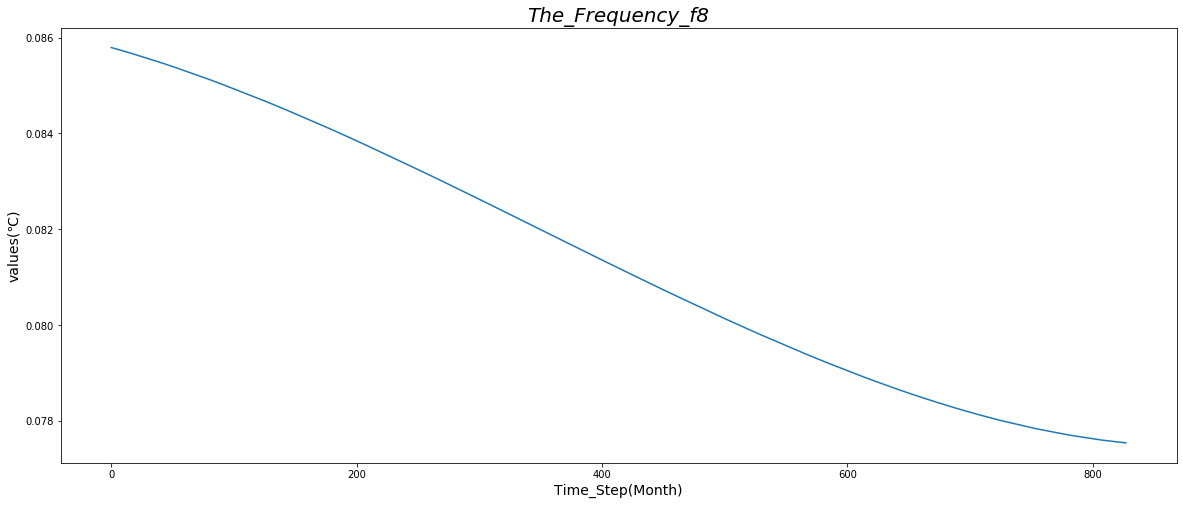

Epoch 1/200
 - 27s - loss: 5.1775e-04
Epoch 2/200
 - 17s - loss: 1.3289e-05
Epoch 3/200
 - 17s - loss: 7.5628e-06
Epoch 4/200
 - 17s - loss: 7.4384e-06
Epoch 5/200
 - 17s - loss: 7.3871e-06
Epoch 6/200
 - 17s - loss: 7.5609e-06
Epoch 7/200
 - 17s - loss: 7.1955e-06
Epoch 8/200
 - 17s - loss: 7.4418e-06
Epoch 9/200
 - 17s - loss: 6.9333e-06
Epoch 10/200
 - 17s - loss: 6.9931e-06
Epoch 11/200
 - 17s - loss: 6.9119e-06
Epoch 12/200
 - 17s - loss: 7.2175e-06
Epoch 13/200
 - 17s - loss: 7.2956e-06
Epoch 14/200
 - 17s - loss: 7.2400e-06
Epoch 15/200
 - 17s - loss: 7.1405e-06
Epoch 16/200
 - 17s - loss: 6.5231e-06
Epoch 17/200
 - 17s - loss: 7.3112e-06
Epoch 18/200
 - 17s - loss: 7.2079e-06
Epoch 19/200
 - 17s - loss: 6.4868e-06
Epoch 20/200
 - 17s - loss: 6.9228e-06
Epoch 21/200
 - 17s - loss: 6.7659e-06
Epoch 22/200
 - 17s - loss: 6.6373e-06
Epoch 23/200
 - 17s - loss: 6.6807e-06
Epoch 24/200
 - 17s - loss: 6.3775e-06
Epoch 25/200
 - 17s - loss: 6.7355e-06
Epoch 26/200
 - 17s - loss: 6.7029

(66, 12)


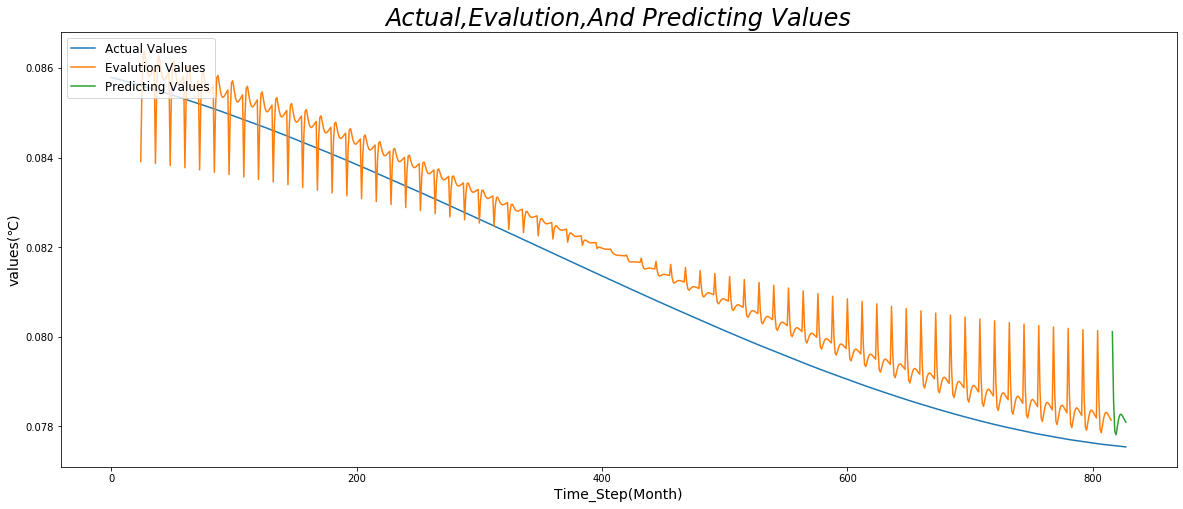

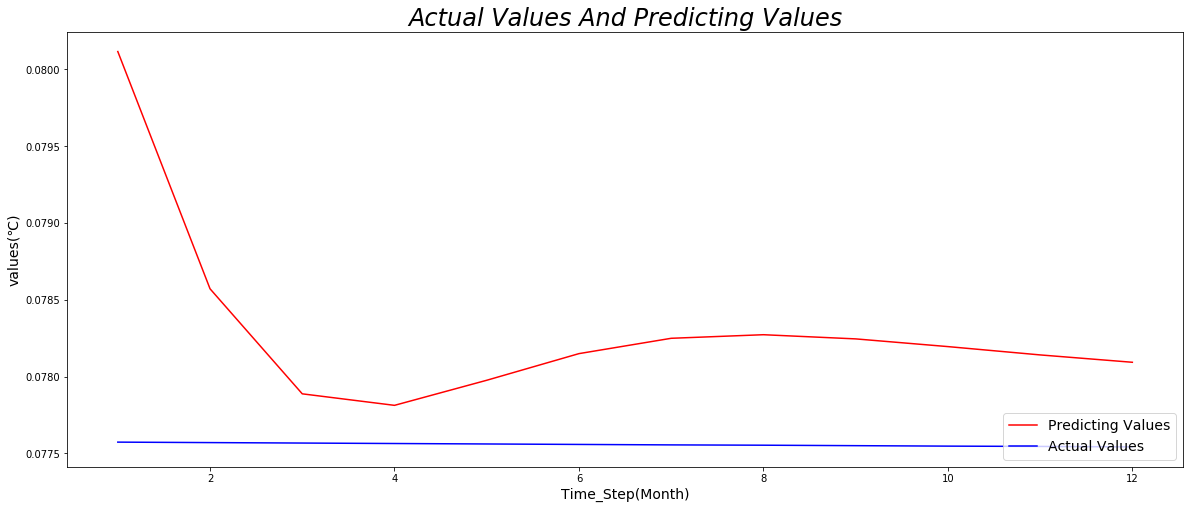

In [17]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][::]
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    

    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [18]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.08011626]
 [0.07857207]
 [0.07788834]
 [0.07781342]
 [0.07797667]
 [0.07815009]
 [0.07824986]
 [0.07827315]
 [0.07824598]
 [0.07819579]
 [0.07814167]
 [0.07809376]]
[array([-0.28373  , -0.20753  , -0.069358 ,  0.029479 ,  0.18765  ,
        0.20383  , -0.017003 , -0.14515  , -0.14641  ,  0.0092768,
        0.1346   ,  0.035037 ]), array([-0.29143 , -0.354   , -0.38141 , -0.36968 , -0.31534 , -0.21508 ,
       -0.071875,  0.086582,  0.22809 ,  0.32458 ,  0.36537 ,  0.34646 ]), array([0.0056482, 0.12307  , 0.23839  , 0.34909  , 0.45314  , 0.54868  ,
       0.63381  , 0.70665  , 0.76531  , 0.80793  , 0.83261  , 0.83806  ]), array([-0.88131, -0.90671, -0.92735, -0.94342, -0.95507, -0.96249,
       -0.96584, -0.96529, -0.96101, -0.95309, -0.94162, -0.92675]), array([0.37911, 0.37411, 0.36941, 0.36506, 0.36112, 0.35764, 0.35466,
       0.35226, 0.35045, 0.34923, 0.34856, 0.34841]), array([0.1436 , 0.14239, 0.14109, 0.13969, 0.1382 , 0.13661, 0.13494,
       0.13318, 0.13133, 0.1294 , 0.1

In [19]:
true_values=np.zeros((12,1))
for i in range(len(prediction_in_one)):
    print ("observe value:{0}".format(real_in_one[i]))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)

observe value:[-0.28373   -0.20753   -0.069358   0.029479   0.18765    0.20383
 -0.017003  -0.14515   -0.14641    0.0092768  0.1346     0.035037 ]
[[-0.28373  ]
 [-0.20753  ]
 [-0.069358 ]
 [ 0.029479 ]
 [ 0.18765  ]
 [ 0.20383  ]
 [-0.017003 ]
 [-0.14515  ]
 [-0.14641  ]
 [ 0.0092768]
 [ 0.1346   ]
 [ 0.035037 ]]
[[-0.28]
 [-0.21]
 [-0.07]
 [ 0.03]
 [ 0.19]
 [ 0.2 ]
 [-0.02]
 [-0.15]
 [-0.15]
 [ 0.01]
 [ 0.13]
 [ 0.04]]
observe value:[-0.29143  -0.354    -0.38141  -0.36968  -0.31534  -0.21508  -0.071875
  0.086582  0.22809   0.32458   0.36537   0.34646 ]
[[-0.57516  ]
 [-0.56153  ]
 [-0.450768 ]
 [-0.340201 ]
 [-0.12769  ]
 [-0.01125  ]
 [-0.088878 ]
 [-0.058568 ]
 [ 0.08168  ]
 [ 0.3338568]
 [ 0.49997  ]
 [ 0.381497 ]]
[[-0.58]
 [-0.56]
 [-0.45]
 [-0.34]
 [-0.13]
 [-0.01]
 [-0.09]
 [-0.06]
 [ 0.08]
 [ 0.33]
 [ 0.5 ]
 [ 0.38]]
observe value:[0.0056482 0.12307   0.23839   0.34909   0.45314   0.54868   0.63381
 0.70665   0.76531   0.80793   0.83261   0.83806  ]
[[-0.5695118]
 [-0.43846 

In [20]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[-0.28027475 -0.27639335 -0.2599154  -0.21498375 -0.13430054 -0.03767182
  0.03699464  0.07342057  0.08663569  0.08693226  0.07582673  0.05604677]
[-0.28027475 -0.27639335 -0.25991541 -0.21498375 -0.13430054 -0.03767182
  0.03699464  0.07342057  0.08663569  0.08693226  0.07582673  0.05604677]
the 1 frequence:
predicted_value:[-0.25165883 -0.2165601  -0.1448243  -0.07086203 -0.00313809  0.06134682
  0.11839215  0.15482046  0.15707561  0.12054753  0.05377955 -0.0239163 ]
[-0.53193358 -0.49295345 -0.40473971 -0.28584578 -0.13743864  0.023675
  0.15538678  0.22824103  0.2437113   0.20747979  0.12960627  0.03213047]
the 2 frequence:
predicted_value:[0.02339732 0.14063267 0.24678627 0.33499172 0.4042502  0.4598856
 0.506124   0.544985   0.5766487  0.600327   0.61492133 0.6194895 ]
[-0.50853625 -0.35232078 -0.15795344  0.04914594  0.26681157  0.4835606
  0.6615108   0.77322602  0.82036001  0.8078068   0.7445276   0.6516199

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
%matplotlib inline
round_true_values=np.array([-0.9,-0.8,-0.6,-0.4,-0.1,0.1,0.1,0.2,0.4,0.7,0.9,0.8])


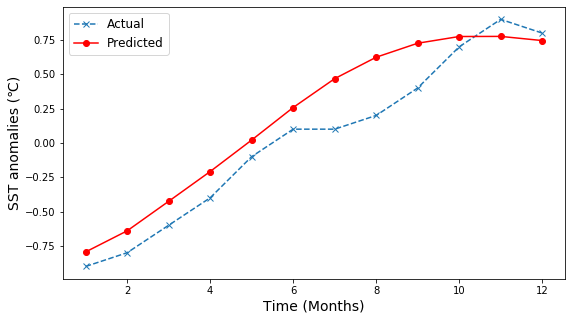

In [23]:
import os
import matplotlib.pyplot as plt
import numpy as np

if(os.path.exists('12_months_valiation_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_valiation_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

actual_values_2018=[-0.9,-0.8,-0.6,-0.4,-0.1,0.1,0.1,0.2,0.4,0.7,0.9,0.8]
predicted_values_2018=predicted_values
plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,np.array(actual_values_2018).reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,np.array(predicted_values_2018).reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 
plt.show()